In [1]:
from google.colab import files
uploaded = files.upload()

Saving ToothNumber_TaskDataset (2).zip to ToothNumber_TaskDataset (2).zip


In [2]:
!unzip /content/ToothNumber_TaskDataset.zip -d ./

Archive:  /content/ToothNumber_TaskDataset.zip
   creating: ./ToothNumber_TaskDataset/
   creating: ./ToothNumber_TaskDataset/images/
  inflating: ./ToothNumber_TaskDataset/images/00147087-20240918-120248027.jpg  
  inflating: ./ToothNumber_TaskDataset/images/0337fb14-20240822-124747143.jpg  
  inflating: ./ToothNumber_TaskDataset/images/05473f26-20240924-154033777.jpg  
  inflating: ./ToothNumber_TaskDataset/images/05ff01fa-20250108-115407401.jpg  
  inflating: ./ToothNumber_TaskDataset/images/061339f1-20240911-110938655.jpg  
  inflating: ./ToothNumber_TaskDataset/images/069750f6-20240914-102814322.jpg  
  inflating: ./ToothNumber_TaskDataset/images/084c3562-20240827-154718191.jpg  
  inflating: ./ToothNumber_TaskDataset/images/0ba65172-20240821-105924223.jpg  
  inflating: ./ToothNumber_TaskDataset/images/0c4cebbe-20240813-144203674.jpg  
  inflating: ./ToothNumber_TaskDataset/images/0fcae64f-20241217-121556078.jpg  
  inflating: ./ToothNumber_TaskDataset/images/0fd502a1-20250123-11

In [4]:
!pip install -q ultralytics>=8.0.0
!pip install -q torch torchvision
!pip install -q opencv-python-headless
!pip install -q matplotlib seaborn plotly
!pip install -q scikit-learn pandas numpy
!pip install -q tqdm

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import json
import random
import shutil
import glob
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from ultralytics import YOLO
import zipfile
from tqdm import tqdm

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [47]:
FDI_CLASS_MAPPING = {
    0: 13, 1: 23, 2: 33, 3: 43,      # Canines
    4: 21, 5: 41, 6: 31, 7: 11,      # Central Incisors
    8: 16, 9: 26, 10: 36, 11: 46,    # First Molars
    12: 14, 13: 34, 14: 44, 15: 24,  # First Premolars
    16: 22, 17: 32, 18: 42, 19: 12,  # Lateral Incisors
    20: 17, 21: 27, 22: 37, 23: 47,  # Second Molars
    24: 15, 25: 25, 26: 35, 27: 45,  # Second Premolars
    28: 18, 29: 28, 30: 38, 31: 48   # Third Molars
}

CLASS_NAMES = {
    0: "Canine (13)", 1: "Canine (23)", 2: "Canine (33)", 3: "Canine (43)",
    4: "Central Incisor (21)", 5: "Central Incisor (41)", 6: "Central Incisor (31)", 7: "Central Incisor (11)",
    8: "First Molar (16)", 9: "First Molar (26)", 10: "First Molar (36)", 11: "First Molar (46)",
    12: "First Premolar (14)", 13: "First Premolar (34)", 14: "First Premolar (44)", 15: "First Premolar (24)",
    16: "Lateral Incisor (22)", 17: "Lateral Incisor (32)", 18: "Lateral Incisor (42)", 19: "Lateral Incisor (12)",
    20: "Second Molar (17)", 21: "Second Molar (27)", 22: "Second Molar (37)", 23: "Second Molar (47)",
    24: "Second Premolar (15)", 25: "Second Premolar (25)", 26: "Second Premolar (35)", 27: "Second Premolar (45)",
    28: "Third Molar (18)", 29: "Third Molar (28)", 30: "Third Molar (38)", 31: "Third Molar (48)"
}

CONFIG = {
    'NUM_CLASSES': 32,
    'MODEL_NAME': 'yolov8m',
    'IMG_SIZE': 832,
    'BATCH_SIZE': 8,
    'EPOCHS': 150,
    'LEARNING_RATE': 0.005,
    'CONFIDENCE_THRESHOLD': 0.4,
    'IOU_THRESHOLD': 0.3,
}


In [6]:
# Create directories
directories = [
    "/content/dental_dataset/raw/images",
    "/content/dental_dataset/raw/labels",
    "/content/dental_dataset/processed/train/images",
    "/content/dental_dataset/processed/train/labels",
    "/content/dental_dataset/processed/val/images",
    "/content/dental_dataset/processed/val/labels",
    "/content/dental_dataset/processed/test/images",
    "/content/dental_dataset/processed/test/labels",
    "/content/results/models",
    "/content/results/plots",
    "/content/results/predictions",
    "/content/results/evaluation"
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)

In [17]:
def validate_dental_dataset():

    images_dir = "/content/ToothNumber_TaskDataset/images"
    labels_dir = "/content/ToothNumber_TaskDataset/labels"

    image_files = [f for f in os.listdir(images_dir)
                   if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

    print(f"Found {len(image_files)} images")
    print(f"Found {len(label_files)} label files")

    # Check pairing
    image_stems = {os.path.splitext(f)[0] for f in image_files}
    label_stems = {os.path.splitext(f)[0] for f in label_files}

    image_stems = sorted(list(image_stems))
    label_stems = sorted(list(label_stems))


    matched = set(image_stems) & set(label_stems)
    missing_labels = set(image_stems) - set(label_stems)
    missing_images = set(label_stems) - set(image_stems)

    print(f"\n PAIRING CHECK:")
    print(f" Matched pairs: {len(matched)}")
    print(f" Images without labels: {len(missing_labels)}")
    print(f" Labels without images: {len(missing_images)}")

    # Validate label format
    all_classes = []
    issues = []

    for label_file in label_files[:20]:
        try:
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                lines = f.readlines()

            for line_num, line in enumerate(lines, 1):
                line = line.strip()
                if not line:
                    continue

                parts = line.split()
                if len(parts) != 5:
                    issues.append(f"{label_file}:{line_num} - Expected 5 values")
                    continue

                try:
                    class_id = int(parts[0])
                    x, y, w, h = map(float, parts[1:5])

                    if not (0 <= class_id <= 31):
                        issues.append(f"{label_file}:{line_num} - Invalid class {class_id}")

                    if not all(0 <= coord <= 1 for coord in [x, y, w, h]):
                        issues.append(f"{label_file}:{line_num} - Invalid coordinates")

                    all_classes.append(class_id)

                except ValueError:
                    issues.append(f"{label_file}:{line_num} - Invalid numbers")

        except Exception as e:
            issues.append(f"{label_file} - Read error")

    # Class distribution
    if all_classes:
        class_counts = Counter(all_classes)
        print(f"\n LABEL ANALYSIS:")
        print(f" Total annotations: {len(all_classes)}")
        print(f" Unique classes: {len(class_counts)}/32")
        print(f" Avg per file: {len(all_classes)/len(label_files):.1f}")

        print(f"\n Class distribution (top 10):")
        for class_id, count in class_counts.most_common(10):
            print(f" Class {class_id:2d}: {count:3d} × {CLASS_NAMES[class_id]}")

    print(f"\n Issues found: {len(issues)}")
    if issues:
        for issue in issues[:5]:
            print(f"   - {issue}")

    # Assessment
    ready = len(matched) >= 10 and len(issues) < len(label_files) * 0.1
    print(f"\n{' DATASET READY!' if ready else ' NEEDS FIXES'}")

    return {
        'images': len(image_files),
        'labels': len(label_files),
        'matched': len(matched),
        'classes': len(set(all_classes)) if all_classes else 0,
        'ready': ready
    }

# Run validation
validation_results = validate_dental_dataset()

Found 497 images
Found 497 label files

 PAIRING CHECK:
 Matched pairs: 497
 Images without labels: 0
 Labels without images: 0

 LABEL ANALYSIS:
 Total annotations: 574
 Unique classes: 32/32
 Avg per file: 1.2

 Class distribution (top 10):
 Class 20:  20 × Second Molar (17)
 Class  7:  20 × Central Incisor (11)
 Class  4:  20 × Central Incisor (21)
 Class 21:  20 × Second Molar (27)
 Class 27:  20 × Second Premolar (45)
 Class 18:  20 × Lateral Incisor (42)
 Class  5:  20 × Central Incisor (41)
 Class  6:  20 × Central Incisor (31)
 Class 17:  20 × Lateral Incisor (32)
 Class  2:  20 × Canine (33)

 Issues found: 0

 DATASET READY!


In [20]:
def split_dataset():
    """Split dataset into train/val/test (80/10/10)"""

    images_dir = "/content/ToothNumber_TaskDataset/images"
    labels_dir = "/content/ToothNumber_TaskDataset/labels"

    # Find matching pairs
    image_files = [f for f in os.listdir(images_dir)
                   if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    # Create image-label pairs
    pairs = []
    for img_file in image_files:
        img_stem = os.path.splitext(img_file)[0]
        label_file = f"{img_stem}.txt"
        label_path = os.path.join(labels_dir, label_file)

        if os.path.exists(label_path):
            pairs.append((img_file, label_file))

    print(f"Found {len(pairs)} matching pairs")

    # Shuffle and split
    random.seed(42)
    random.shuffle(pairs)

    total = len(pairs)
    train_end = int(total * 0.8)
    val_end = train_end + int(total * 0.1)

    train_pairs = pairs[:train_end]
    val_pairs = pairs[train_end:val_end]
    test_pairs = pairs[val_end:]

    print(f"Split: Train={len(train_pairs)}, Val={len(val_pairs)}, Test={len(test_pairs)}")

    # Copy files
    splits = {'train': train_pairs, 'val': val_pairs, 'test': test_pairs}

    for split_name, split_pairs in splits.items():
        for img_file, label_file in tqdm(split_pairs, desc=f"Copying {split_name}"):
            # Copy image
            src_img = os.path.join(images_dir, img_file)
            dst_img = f"/content/dental_dataset/processed/{split_name}/images/{img_file}"
            shutil.copy2(src_img, dst_img)

            # Copy label
            src_lbl = os.path.join(labels_dir, label_file)
            dst_lbl = f"/content/dental_dataset/processed/{split_name}/labels/{label_file}"
            shutil.copy2(src_lbl, dst_lbl)

    print("✅ Dataset splitting completed!")
    return len(train_pairs), len(val_pairs), len(test_pairs)

# Only split if we have data
if validation_results['ready'] and validation_results['matched'] > 0:
    train_count, val_count, test_count = split_dataset()
else:
    print("❌ Please upload and validate your dataset first")

Found 497 matching pairs
Split: Train=397, Val=49, Test=51


Copying test: 100%|██████████| 51/51 [00:00<00:00, 3706.24it/s]

✅ Dataset splitting completed!


In [21]:
data_yaml_content = f"""# Dental Tooth Detection Dataset Configuration
# FDI (Fédération Dentaire Internationale) Numbering System

# Dataset paths
path: /content/dental_dataset/processed
train: train/images
val: val/images
test: test/images

# Number of classes
nc: 32

# Class names - FDI Tooth Numbering System
names:"""

# Add all class names
for i in range(32):
    data_yaml_content += f"\n  {i}: {CLASS_NAMES[i]}"

# Save data.yaml
with open("/content/data.yaml", 'w') as f:
    f.write(data_yaml_content)

print("✅ Created data.yaml configuration")
print("\n📄 Configuration preview:")
print(data_yaml_content[:500] + "...")

# Verify paths exist
train_imgs = len(os.listdir("/content/dental_dataset/processed/train/images"))
val_imgs = len(os.listdir("/content/dental_dataset/processed/val/images"))
test_imgs = len(os.listdir("/content/dental_dataset/processed/test/images"))

print(f"\n📊 Dataset verification:")
print(f"   Train: {train_imgs} images")
print(f"   Val: {val_imgs} images")
print(f"   Test: {test_imgs} images")


✅ Created data.yaml configuration

📄 Configuration preview:
# Dental Tooth Detection Dataset Configuration
# FDI (Fédération Dentaire Internationale) Numbering System

# Dataset paths
path: /content/dental_dataset/processed
train: train/images
val: val/images
test: test/images

# Number of classes
nc: 32

# Class names - FDI Tooth Numbering System
names:
  0: Canine (13)
  1: Canine (23)
  2: Canine (33)
  3: Canine (43)
  4: Central Incisor (21)
  5: Central Incisor (41)
  6: Central Incisor (31)
  7: Central Incisor (11)
  8: First Molar (16)
  9: Firs...

📊 Dataset verification:
   Train: 397 images
   Val: 49 images
   Test: 51 images


In [48]:
def train_enhanced_dental_yolo():

    model = YOLO(f"{CONFIG['MODEL_NAME']}.pt")

    enhanced_train_args = {
        'data': '/content/data.yaml',
        'epochs': CONFIG['EPOCHS'],
        'imgsz': CONFIG['IMG_SIZE'],
        'batch': CONFIG['BATCH_SIZE'],
        'name': 'enhanced_dental_detection',
        'project': '/content/results',
        'patience': 75,
        'save': True,
        'plots': True,
        'device': 0 if torch.cuda.is_available() else 'cpu',
        'workers': 2,
        'optimizer': 'AdamW',
        'lr0': CONFIG['LEARNING_RATE'],
        'lrf': 0.001,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 5,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,
        'box': 7.5,
        'cls': 0.5,
        'dfl': 1.5,

        'hsv_h': 0.02,
        'hsv_s': 0.8,
        'hsv_v': 0.5,
        'degrees': 3.0,
        'translate': 0.15,
        'scale': 0.7,
        'shear': 0.0,
        'perspective': 0.0,
        'flipud': 0.0,
        'fliplr': 0.5,
        'mosaic': 1.0,
        'mixup': 0.1,
        'copy_paste': 0.0,

        'val': True,
        'save_json': True,
        'verbose': True
    }

    start_time = datetime.now()

    try:
        results = model.train(**enhanced_train_args)

        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds()

        return model, results

    except Exception as e:
        print(f"Training failed: {e}")
        print("Try reducing batch size or image size if GPU memory error")
        return None, None

enhanced_model, enhanced_results = train_enhanced_dental_yolo()


Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=3.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.8, hsv_v=0.5, imgsz=832, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.001, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=enhanced_dental_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=75, perspective=0.0, plots=True, pose=12.0, pr

 Training Results:

 Results:


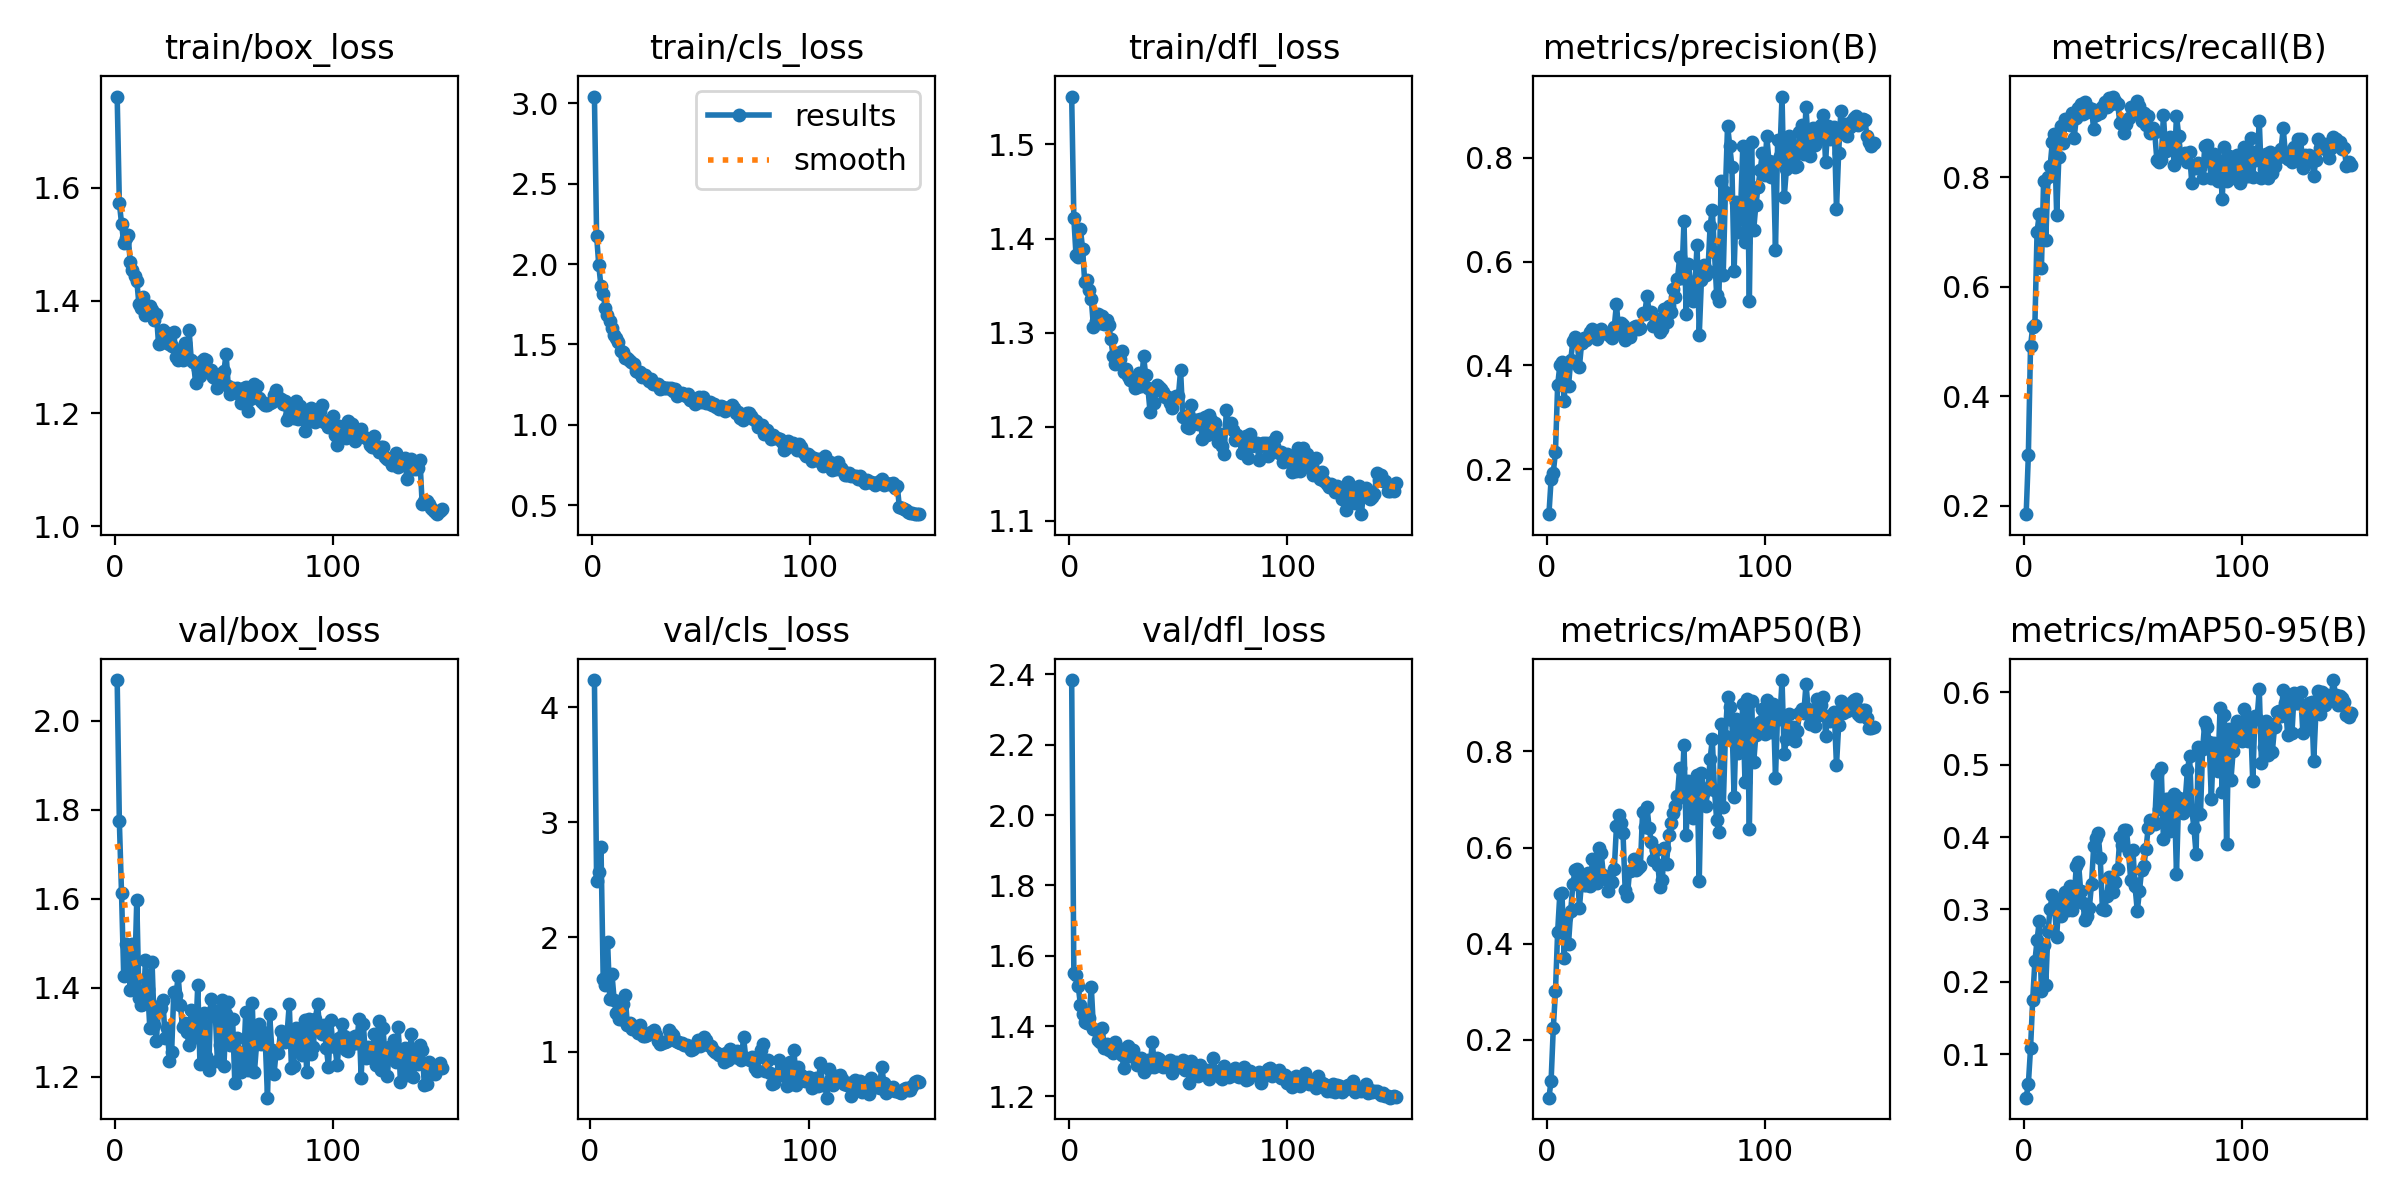


 Confusion Matrix:


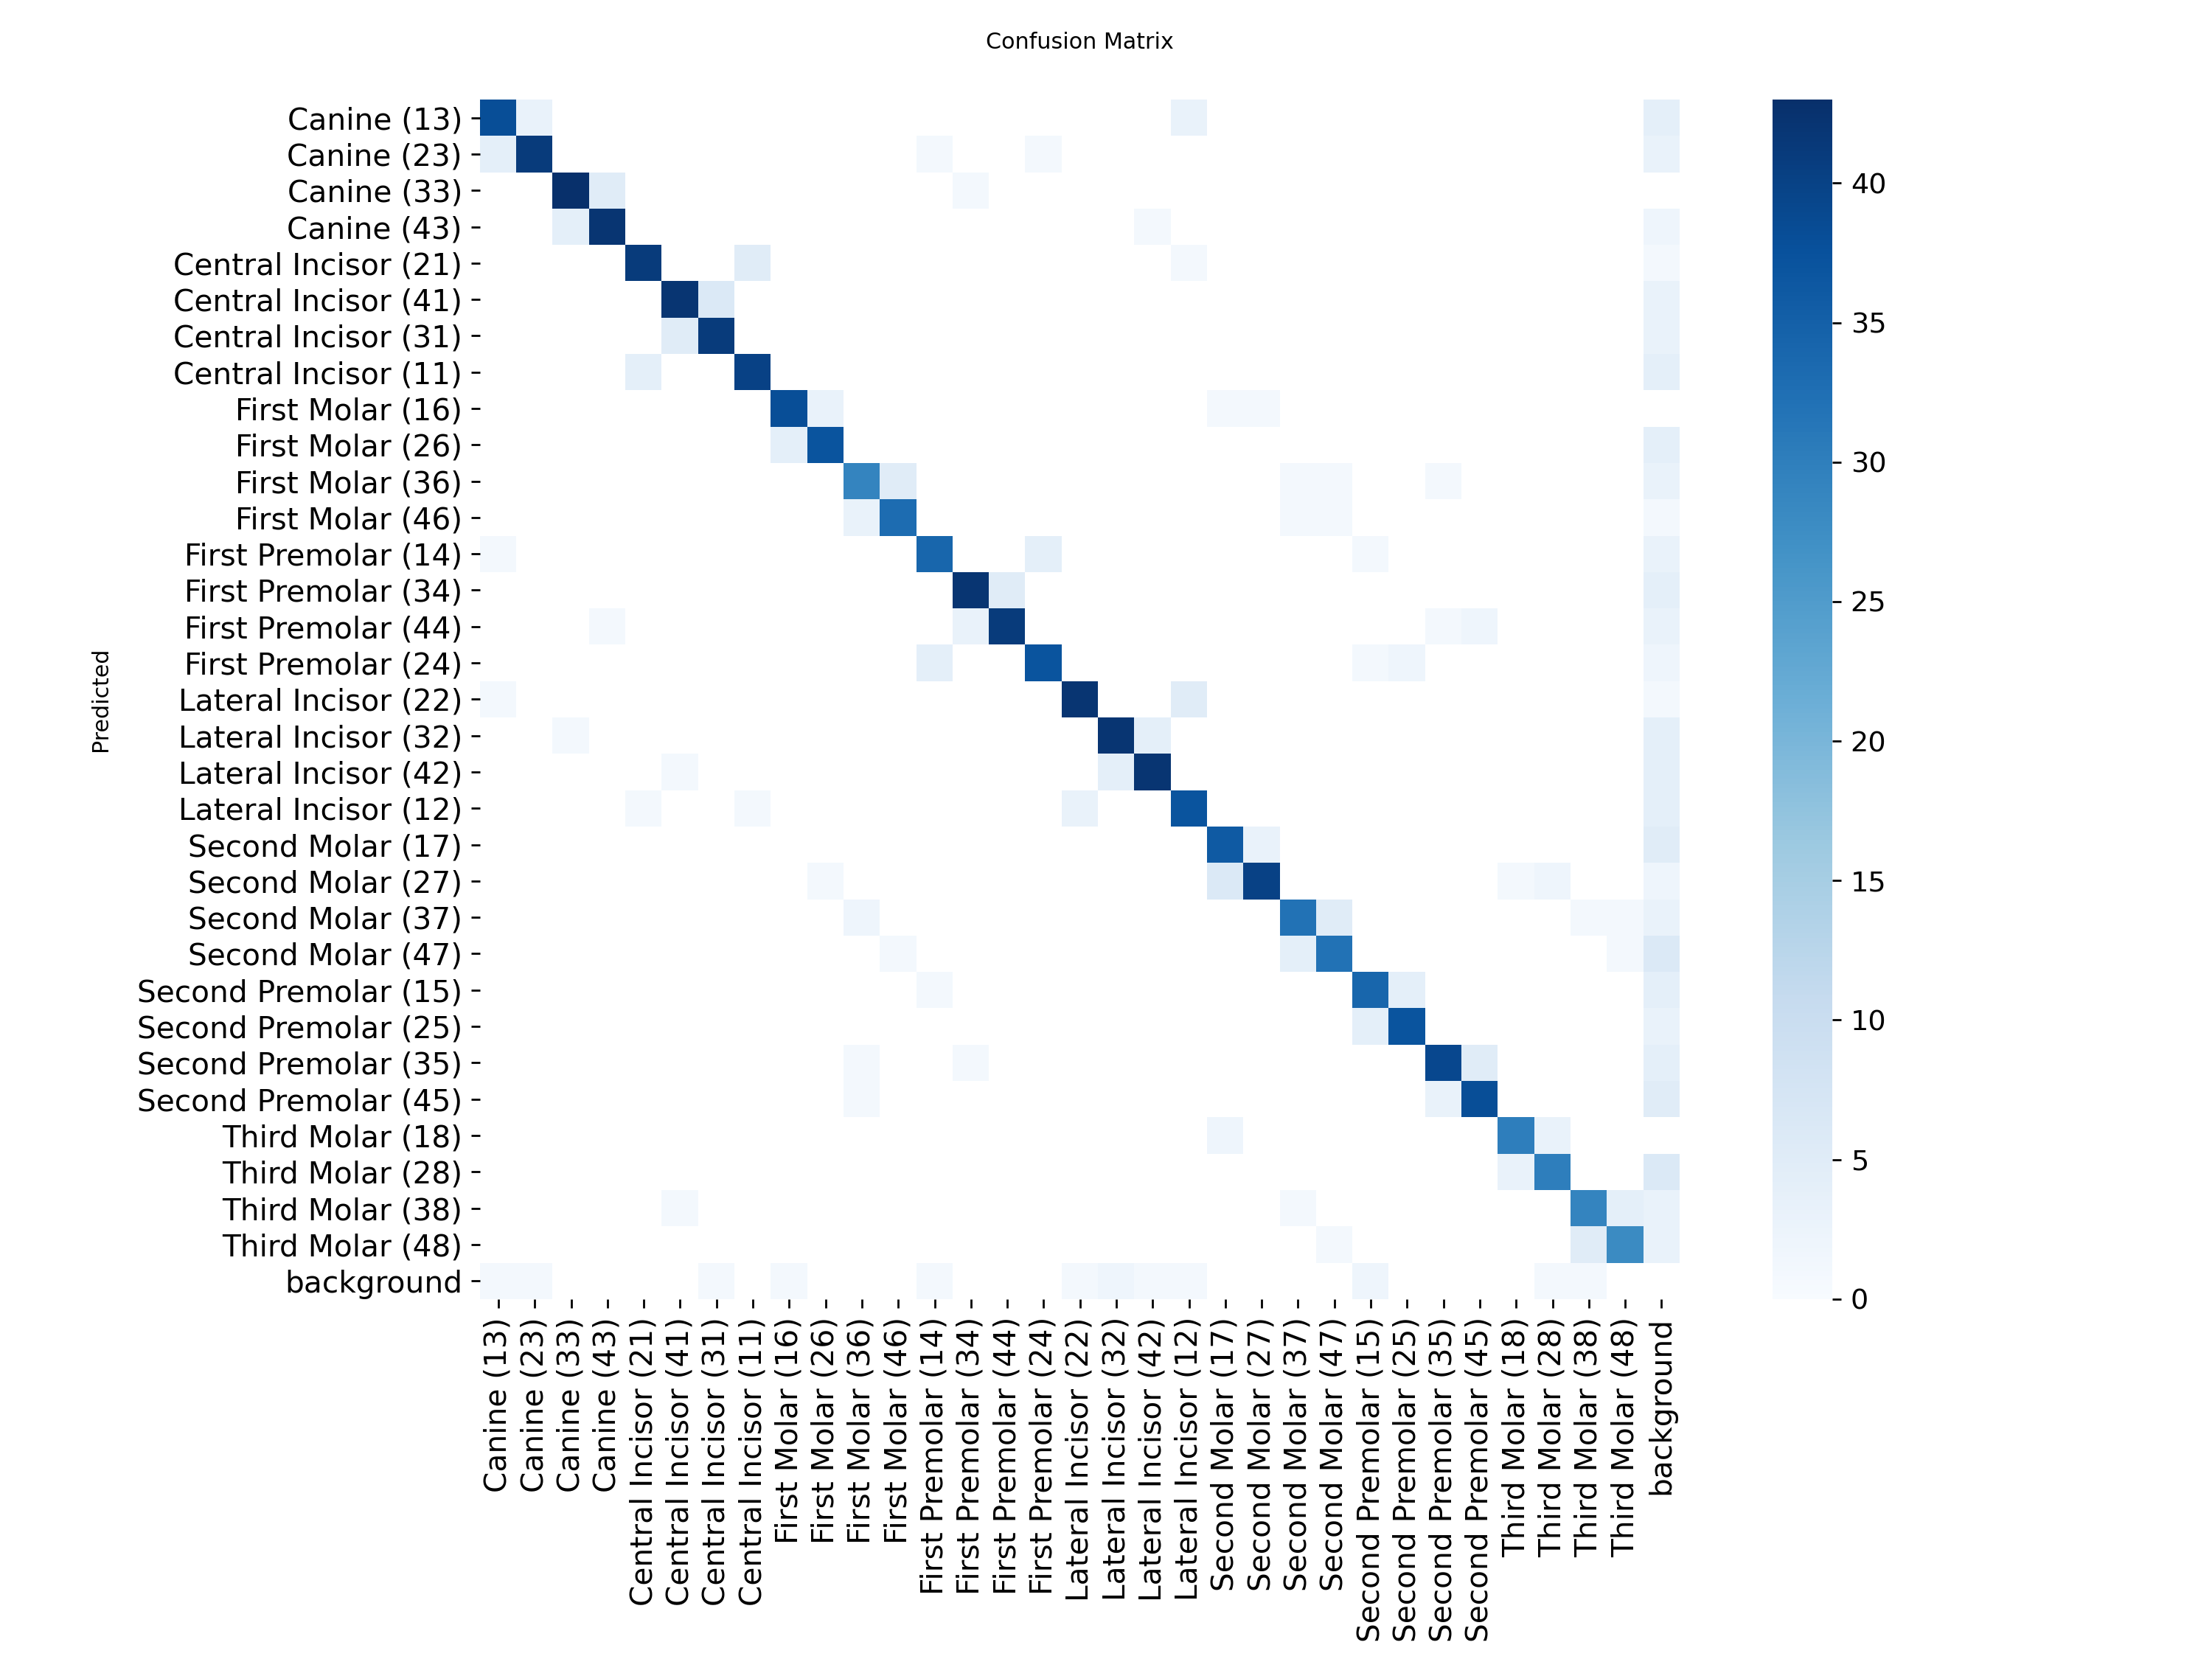


 Final Training Metrics:
   Precision: 0.8290
   Recall: 0.8226
   mAP@0.5: 0.8512
   mAP@0.5:0.95: 0.5710
   Box Loss: 1.0312
   Class Loss: 0.4461


In [49]:
try:
    # Display training plots
    results_dir = "/content/results/enhanced_dental_detection"

    if os.path.exists(results_dir):
        from IPython.display import Image, display

        # List of plots to display
        plots = [
            'results.png',
            'confusion_matrix.png',
            'P_curve.png',
            'R_curve.png',
            'PR_curve.png',
            'F1_curve.png'
        ]

        print(" Training Results:")

        for plot in plots:
            plot_path = os.path.join(results_dir, plot)
            if os.path.exists(plot_path):
                print(f"\n {plot.replace('.png', '').replace('_', ' ').title()}:")
                display(Image(plot_path))

        # Load training metrics
        results_csv = os.path.join(results_dir, 'results.csv')
        if os.path.exists(results_csv):
            df_results = pd.read_csv(results_csv)
            final_metrics = df_results.iloc[-1]

            print(f"\n Final Training Metrics:")
            metrics_to_show = [
                ('metrics/precision(B)', 'Precision'),
                ('metrics/recall(B)', 'Recall'),
                ('metrics/mAP50(B)', 'mAP@0.5'),
                ('metrics/mAP50-95(B)', 'mAP@0.5:0.95'),
                ('train/box_loss', 'Box Loss'),
                ('train/cls_loss', 'Class Loss')
            ]

            for col, name in metrics_to_show:
                if col in final_metrics:
                    print(f"   {name}: {final_metrics[col]:.4f}")

except Exception as e:
    print(f"Error displaying results: {e}")


 Loading model: /content/results/dental_detection/weights/best.pt
 Running validation on test set...
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,137,968 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1538.6±568.2 MB/s, size: 75.3 KB)
val: Scanning /content/dental_dataset/processed/test/labels.cache... 51 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 51/51 56410.7it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.73it/s 5.5s
                   all         51       1437      0.112      0.384      0.147     0.0856
           Canine (13)         48         48     0.0949      0.583      0.183      0.107
           Canine (23)         47         48     0.0948      0.562      0.143     0.0747
           Canine (33)         49         49       0.16      0.245      0.144      0.079
           Canine (43

Processing test images: 100%|██████████| 51/51 [00:00<00:00, 61.11it/s]


✅ Confusion matrix saved to /content/results/confusion_matrix_test_set.png


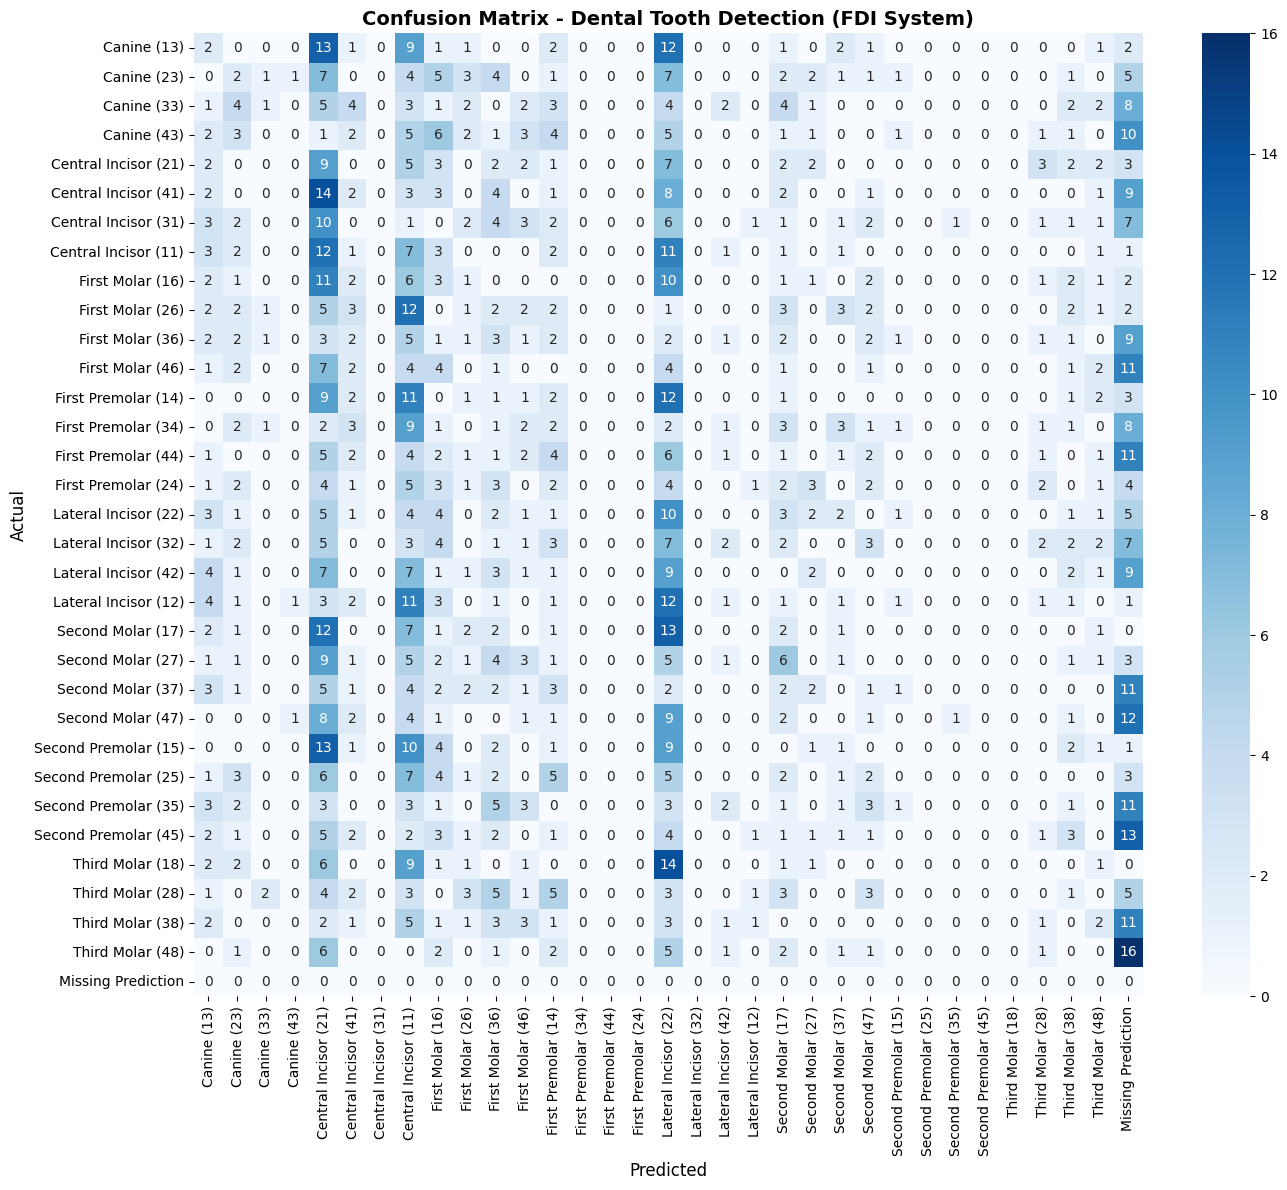

In [57]:
def evaluate_model():
    """Comprehensive model evaluation"""

    model_path = "/content/results/dental_detection/weights/best.pt"
    test_images_dir = "/content/dental_dataset/processed/test/images"

    if not os.path.exists(model_path):
        print(" Trained model not found!")
        return None

    print(f" Loading model: {model_path}")
    model = YOLO(model_path)

    # Run validation
    print(" Running validation on test set...") # Changed to indicate test set
    metrics = model.val(data='/content/data.yaml', split='test') # Explicitly specify test split

    # Extract key metrics
    results = {
        'precision': float(metrics.box.mp),
        'recall': float(metrics.box.mr),
        'map50': float(metrics.box.map50),
        'map50_95': float(metrics.box.map),
        'f1_score': float(2 * metrics.box.mp * metrics.box.mr / (metrics.box.mp + metrics.box.mr + 1e-6))
    }

    print(f"\n Test Set Metrics:") # Changed to indicate test set
    for metric, value in results.items():
        print(f"   {metric}: {value:.4f}")

    # Generate confusion matrix
    print(f"\n Generating confusion matrix...")

    test_images = [f for f in os.listdir(test_images_dir)
                   if f.lower().endswith(('.jpg', '.png', '.jpeg'))]  # Use all test images

    # Ensure that the labels directory exists
    test_labels_dir = "/content/dental_dataset/processed/test/labels"
    if not os.path.exists(test_labels_dir):
        print(f"Test labels directory not found at {test_labels_dir}")
        return model, results # Return results even if confusion matrix can't be generated

    y_true_classes, y_pred_classes = [], [] # Renamed variables for clarity

    for img_file in tqdm(test_images, desc="Processing test images"):
        img_path = os.path.join(test_images_dir, img_file)

        # Get ground truth
        img_stem = os.path.splitext(img_file)[0] # Get just the stem
        label_file = f"{img_stem}.txt" # Construct the label file name correctly
        label_path = os.path.join(test_labels_dir, label_file) # Use the correct test labels directory

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                # Extract only class IDs from ground truth labels
                gt_classes = [int(line.split()[0]) for line in f.readlines() if line.strip()]


            # Get predictions
            # Use the loaded model for prediction
            pred_results = model.predict(img_path, conf=CONFIG['CONFIDENCE_THRESHOLD'], verbose=False) # Use config threshold
            pred_classes = []

            if pred_results and pred_results[0].boxes is not None: # Access boxes correctly from results object
                pred_classes = pred_results[0].boxes.cls.cpu().numpy().astype(int).tolist()

            # Simple matching for confusion matrix
            # Extend the true classes list with ground truth classes
            y_true_classes.extend(gt_classes)

            # For simplicity in confusion matrix generation, we'll pair predictions
            # with ground truth based on the number of ground truth objects.
            # This is a simplification; for more accurate evaluation, you'd need
            # to match predictions to ground truth objects (e.g., using IoU).
            # Here, we'll just take the first N predictions, where N is the number
            # of ground truth objects.
            y_pred_classes.extend(pred_classes[:len(gt_classes)])

            # If there are more ground truths than predictions, pad with a placeholder (e.g., -1)
            if len(pred_classes) < len(gt_classes):
                 y_pred_classes.extend([-1] * (len(gt_classes) - len(pred_classes)))
            # If there are more predictions than ground truths, the extra predictions are ignored
            # in this simplified approach.

    # Plot confusion matrix
    if y_true_classes and y_pred_classes: # Use the renamed variables
        plt.figure(figsize=(14, 12)) # Increased figure size

        # Include -1 for missing predictions in labels
        all_possible_classes = list(range(CONFIG['NUM_CLASSES']))
        # Add -1 to labels if it's in y_pred_classes
        if -1 in y_pred_classes:
            all_possible_classes.append(-1)

        cm = confusion_matrix(y_true_classes, y_pred_classes, labels=all_possible_classes) # Use the renamed variables and all_possible_classes

        # Create class labels including 'Missing Prediction'
        class_labels = [CLASS_NAMES[i] for i in range(CONFIG['NUM_CLASSES'])]
        if -1 in all_possible_classes:
             class_labels.append('Missing Prediction')


        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_labels, yticklabels=class_labels) # Use the correct class labels

        plt.title('Confusion Matrix - Dental Tooth Detection (FDI System)',
                 fontsize=14, fontweight='bold')
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('Actual', fontsize=12)
        plt.xticks(rotation=90) # Increased rotation for better readability
        plt.yticks(rotation=0)
        plt.tight_layout()

        # Save confusion matrix
        confusion_matrix_path = '/content/results/confusion_matrix_test_set.png' # Changed filename to indicate test set
        plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
        print(f"✅ Confusion matrix saved to {confusion_matrix_path}")
        plt.show()

    return model, results

# Run evaluation
if os.path.exists("/content/results/dental_detection/weights/best.pt"):
    eval_model, eval_metrics = evaluate_model()

🔍 GENERATING SAMPLE PREDICTIONS...
Processing sample 1/5: 695829ba-20240803-122506348.jpg


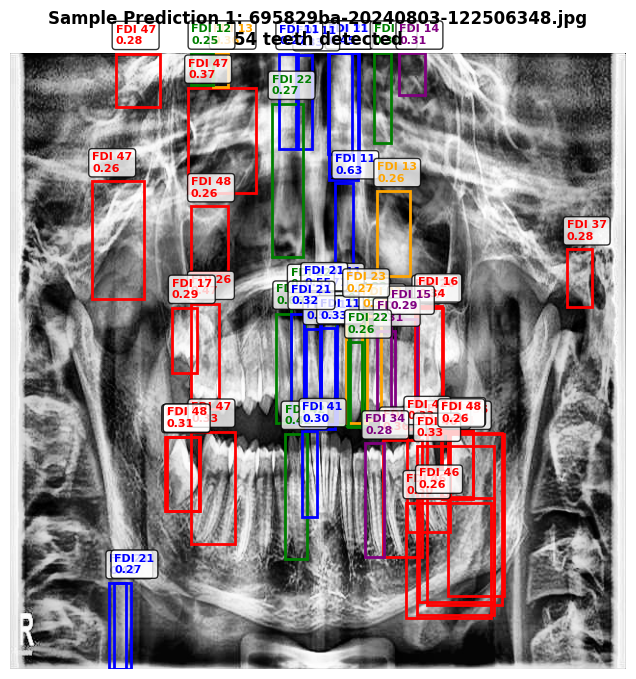

   Saved: /content/results/predictions/sample_01.png
Processing sample 2/5: cate10-00102_jpg.rf.a13b825b4c6206c659c41586a243895d.jpg


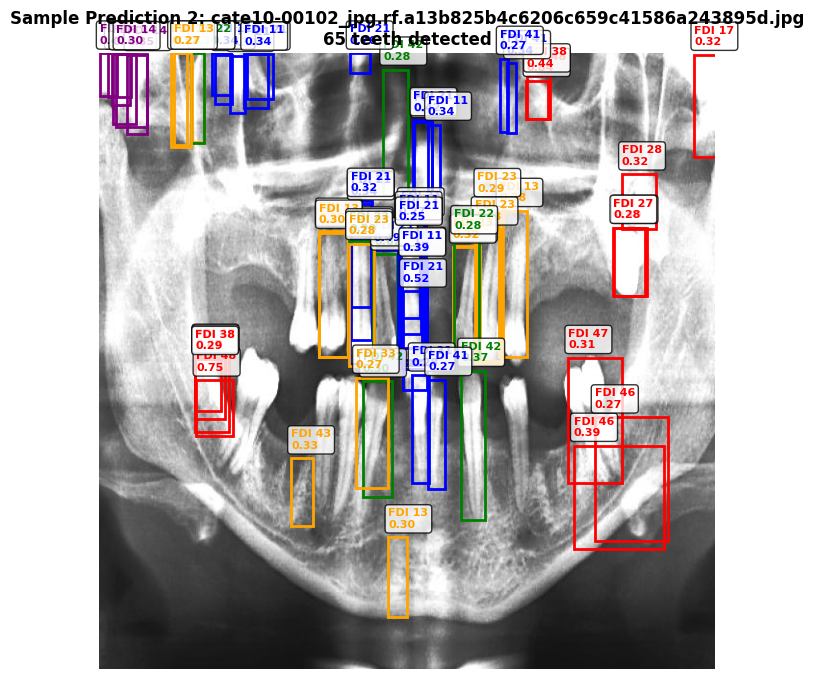

   Saved: /content/results/predictions/sample_02.png
Processing sample 3/5: d01a3242-20240712-104320300.jpg


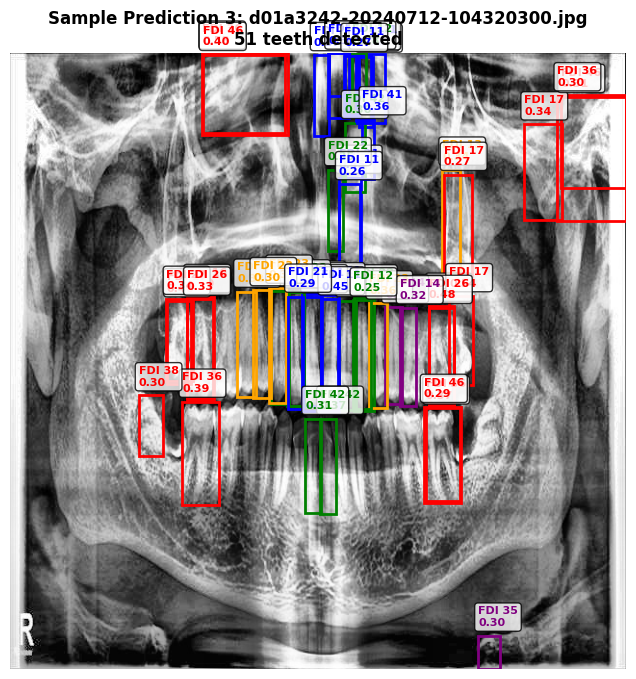

   Saved: /content/results/predictions/sample_03.png
Processing sample 4/5: bd3e04e6-20240808-115757352.jpg


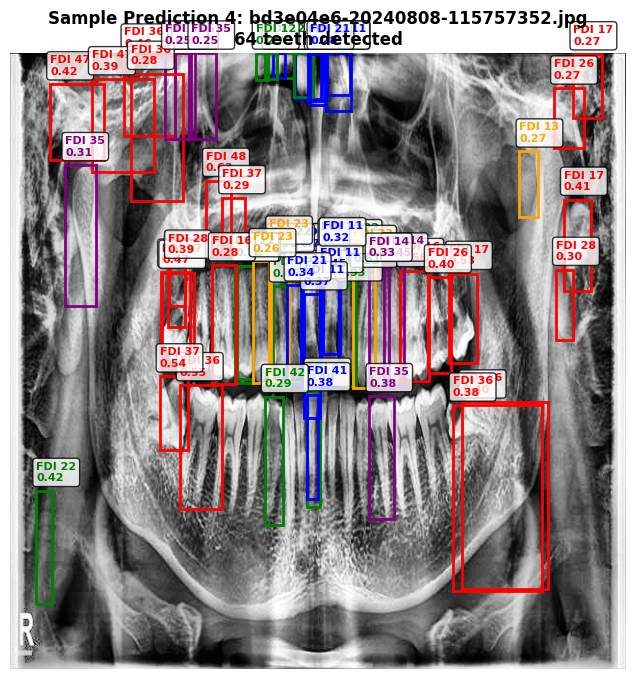

   Saved: /content/results/predictions/sample_04.png
Processing sample 5/5: cate10-00084_jpg.rf.85ec6a4ebe490441c7810204ac7349e8.jpg


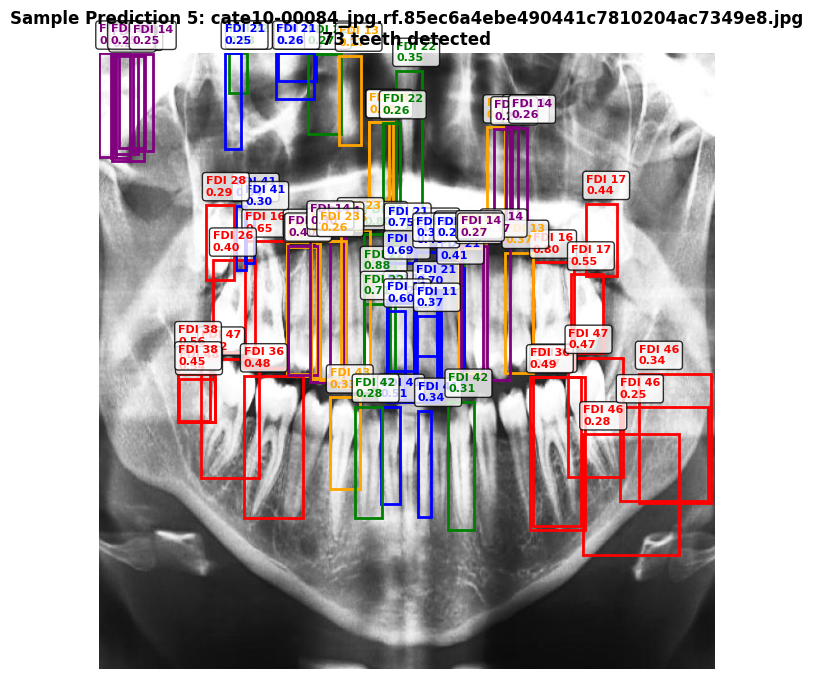

   Saved: /content/results/predictions/sample_05.png

✅ Generated 5 sample predictions!


In [51]:
def generate_sample_predictions(num_samples=5):

    model_path = "/content/results/dental_detection/weights/best.pt"
    test_images_dir = "/content/dental_dataset/processed/test/images"

    if not os.path.exists(model_path):
        return

    model = YOLO(model_path)

    # Get test images
    test_images = [f for f in os.listdir(test_images_dir)
                   if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if len(test_images) < num_samples:
        num_samples = len(test_images)

    sample_images = random.sample(test_images, num_samples)

    # Create predictions directory
    os.makedirs("/content/results/predictions", exist_ok=True)

    for i, img_file in enumerate(sample_images, 1):
        print(f"Processing sample {i}/{num_samples}: {img_file}")

        img_path = os.path.join(test_images_dir, img_file)

        # Run prediction
        results = model.predict(img_path, conf=0.25, verbose=False)

        # Load and display image
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(image_rgb)

        # Draw predictions
        if results and results[0].boxes is not None: # Access boxes from the first element of the results list
            boxes = results[0].boxes

            for j in range(len(boxes)):
                box = boxes.xyxy[j].cpu().numpy()
                cls = int(boxes.cls[j].cpu().numpy())
                conf = float(boxes.conf[j].cpu().numpy())

                # Get FDI number and color
                fdi_number = FDI_CLASS_MAPPING.get(cls, cls)
                tooth_name = CLASS_NAMES.get(cls, f"Class {cls}")

                # Color coding
                if 'Central Incisor' in tooth_name:
                    color = 'blue'
                elif 'Lateral Incisor' in tooth_name:
                    color = 'green'
                elif 'Canine' in tooth_name:
                    color = 'orange'
                elif 'Premolar' in tooth_name:
                    color = 'purple'
                elif 'Molar' in tooth_name:
                    color = 'red'
                else:
                    color = 'yellow'

                # Draw bounding box
                rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                   fill=False, color=color, linewidth=2)
                ax.add_patch(rect)

                # Add label
                label = f'FDI {fdi_number}\n{conf:.2f}'
                ax.text(box[0], box[1]-10, label, fontsize=8, color=color,
                       fontweight='bold', bbox=dict(boxstyle='round,pad=0.3',
                                                   facecolor='white', alpha=0.8))

        ax.set_title(f'Sample Prediction {i}: {img_file}\n{len(boxes) if "boxes" in locals() else 0} teeth detected',
                    fontsize=12, fontweight='bold')
        ax.axis('off')

        # Save image
        save_path = f'/content/results/predictions/sample_{i:02d}.png'
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()


# Generate sample predictions if model exists
if 'eval_model' in locals():
    generate_sample_predictions(5)

   🦷 Enhanced AnatomicalCorrector initialized
   📊 Confidence threshold: 0.4
   📏 Spacing threshold: 0.1

📍 Processing sample 1/3: 23f1d012-20240628-115132889.jpg
   🔍 Raw YOLO detections: 40
   🔍 Processing 40 raw detections...
   🔍 Filtered out 7 low confidence detections
   🔄 NMS removed 1 overlapping detections
   📊 Arch separation: 16 upper, 16 lower
   📐 Quadrant separation: 8 left, 8 right teeth
   🦷 Processed upper right quadrant (1): 8 teeth
   🦷 Processed upper left quadrant (2): 8 teeth
   📐 Quadrant separation: 8 left, 8 right teeth
   🦷 Processed lower left quadrant (3): 8 teeth
   🦷 Processed lower right quadrant (4): 8 teeth
   ✅ Applied anatomical corrections to 32 detections
   ✅ Anatomically corrected detections: 32


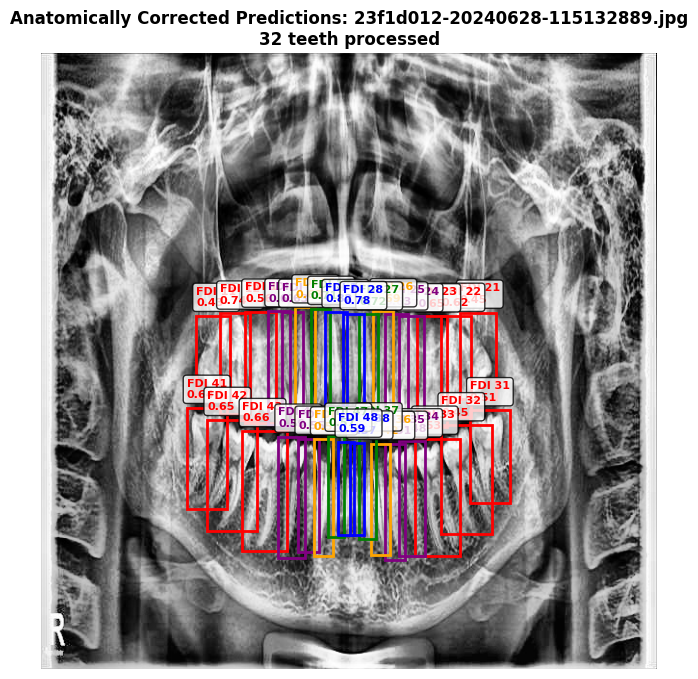


📍 Processing sample 2/3: 05ff01fa-20250108-115407401.jpg
   🔍 Raw YOLO detections: 32
   🔍 Processing 32 raw detections...
   🔄 NMS removed 2 overlapping detections
   📊 Arch separation: 15 upper, 15 lower
   📐 Quadrant separation: 8 left, 7 right teeth
   🦷 Processed upper right quadrant (1): 7 teeth
   🦷 Processed upper left quadrant (2): 8 teeth
   📐 Quadrant separation: 7 left, 8 right teeth
   🦷 Processed lower left quadrant (3): 7 teeth
   🦷 Processed lower right quadrant (4): 8 teeth
   ✅ Applied anatomical corrections to 30 detections
   ✅ Anatomically corrected detections: 30


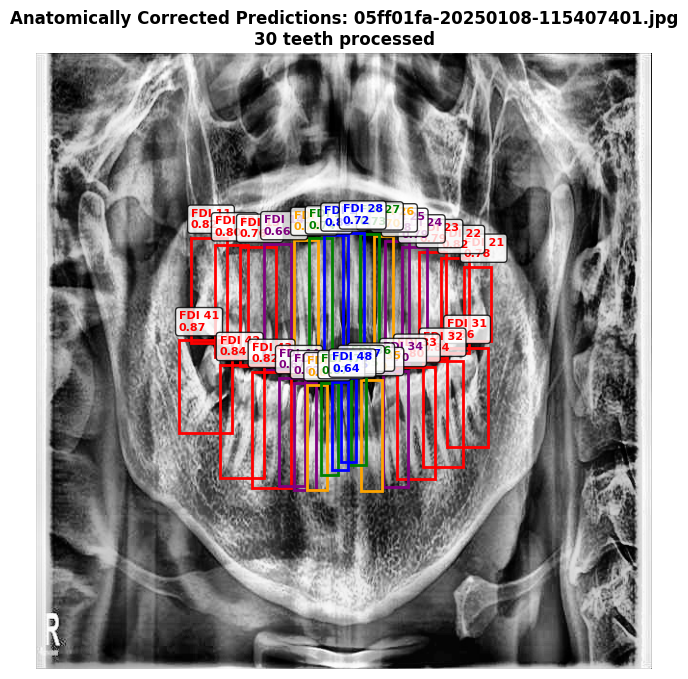


📍 Processing sample 3/3: 7b27f339-20240914-101612388.jpg
   🔍 Raw YOLO detections: 32
   🔍 Processing 32 raw detections...
   📊 Arch separation: 16 upper, 16 lower
   📐 Quadrant separation: 8 left, 8 right teeth
   🦷 Processed upper right quadrant (1): 8 teeth
   🦷 Processed upper left quadrant (2): 8 teeth
   📐 Quadrant separation: 8 left, 8 right teeth
   🦷 Processed lower left quadrant (3): 8 teeth
   🦷 Processed lower right quadrant (4): 8 teeth
   ✅ Applied anatomical corrections to 32 detections
   ✅ Anatomically corrected detections: 32


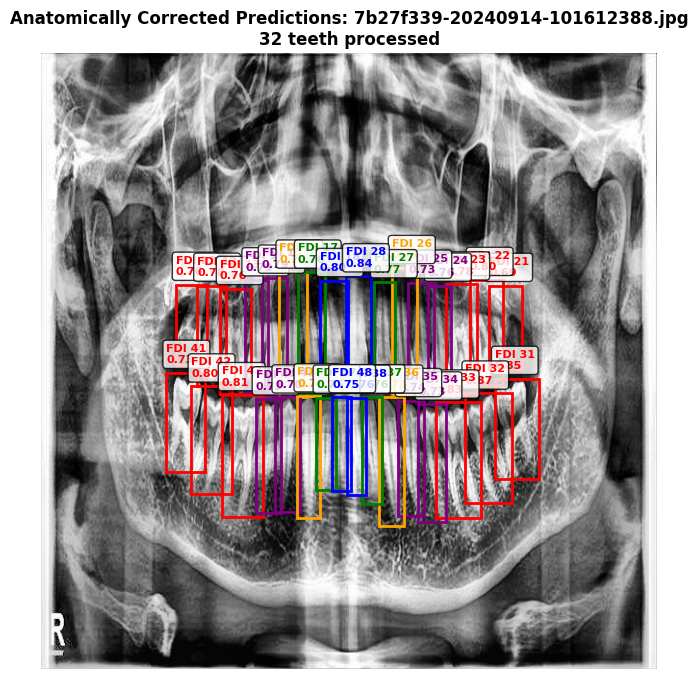

In [56]:
from sklearn.cluster import KMeans

class ImprovedAnatomicalCorrector:
    """Enhanced post-processing with better parameter tuning"""

    def __init__(self, confidence_threshold=0.4, spacing_threshold=0.10, nms_threshold=0.3):
        self.fdi_mapping = FDI_CLASS_MAPPING
        self.confidence_threshold = confidence_threshold
        self.spacing_threshold = spacing_threshold  # ✅ ADJUSTED: Less sensitive
        self.nms_threshold = nms_threshold
        print(f"   🦷 Enhanced AnatomicalCorrector initialized")
        print(f"   📊 Confidence threshold: {confidence_threshold}")
        print(f"   📏 Spacing threshold: {spacing_threshold}")

    def filter_low_confidence(self, detections):
        """Filter out low confidence detections"""

        filtered = [det for det in detections if det.get('confidence', 0) >= self.confidence_threshold]
        removed = len(detections) - len(filtered)

        if removed > 0:
            print(f"   🔍 Filtered out {removed} low confidence detections")

        return filtered

    def apply_nms(self, detections):
        """Apply Non-Maximum Suppression to reduce overlapping detections"""

        if len(detections) <= 1:
            return detections

        # Simple NMS based on IoU
        filtered_detections = []

        for i, det1 in enumerate(detections):
            is_duplicate = False

            for j, det2 in enumerate(filtered_detections):
                # Calculate overlap
                box1 = det1['bbox']
                box2 = det2['bbox']

                # Simple overlap check
                x_overlap = max(0, min(box1[0] + box1[2]/2, box2[0] + box2[2]/2) -
                              max(box1[0] - box1[2]/2, box2[0] - box2[2]/2))
                y_overlap = max(0, min(box1[1] + box1[3]/2, box2[1] + box2[3]/2) -
                              max(box1[1] - box1[3]/2, box2[1] - box2[3]/2))

                overlap_area = x_overlap * y_overlap
                box1_area = box1[2] * box1[3]
                box2_area = box2[2] * box2[3]


                iou = overlap_area / (box1_area + box2_area - overlap_area + 1e-6)

                if iou > self.nms_threshold:
                    # Keep the one with higher confidence
                    if det1.get('confidence', 0) <= det2.get('confidence', 0):
                        is_duplicate = True
                        break

            if not is_duplicate:
                filtered_detections.append(det1)

        removed = len(detections) - len(filtered_detections)
        if removed > 0:
            print(f"   🔄 NMS removed {removed} overlapping detections")

        return filtered_detections

    def separate_arches(self, detections, image_height):
        """✅ IMPROVED: Better arch separation"""

        if len(detections) < 2:
            return detections, []

        # Extract Y-coordinates
        y_coords = np.array([det['bbox'][1] * image_height for det in detections]).reshape(-1, 1)

        try:
            # ✅ IMPROVED: Better clustering parameters
            kmeans = KMeans(n_clusters=2, random_state=42, n_init=20, max_iter=500)
            clusters = kmeans.fit_predict(y_coords)

            cluster_centers = kmeans.cluster_centers_.flatten()
            upper_cluster = 0 if cluster_centers[0] < cluster_centers[1] else 1

            upper_teeth = [det for i, det in enumerate(detections) if clusters[i] == upper_cluster]
            lower_teeth = [det for i, det in enumerate(detections) if clusters[i] != upper_cluster]

            print(f"   📊 Arch separation: {len(upper_teeth)} upper, {len(lower_teeth)} lower")

        except Exception as e:
            print(f"   ⚠️ Clustering failed, using fallback method")
            # Fallback: use median split
            median_y = np.median(y_coords)
            upper_teeth = [det for det in detections if det['bbox'][1] * image_height < median_y]
            lower_teeth = [det for det in detections if det['bbox'][1] * image_height >= median_y]

        return upper_teeth, lower_teeth

    def separate_left_right(self, teeth_detections, image_width):
        """✅ IMPROVED: Divide left vs right quadrants using X-midline"""

        midline = image_width / 2

        left_teeth = []
        right_teeth = []

        for det in teeth_detections:
            # Use the x_center from the normalized bbox
            x_center_normalized = det['bbox'][0]
            x_center = x_center_normalized * image_width  # Convert to pixel coordinates

            if x_center < midline:
                right_teeth.append(det)  # Patient's right is image left
            else:
                left_teeth.append(det)   # Patient's left is image right

        print(f"   📐 Quadrant separation: {len(left_teeth)} left, {len(right_teeth)} right teeth")
        return left_teeth, right_teeth


    def sort_teeth_horizontally(self, teeth_detections, image_width, quadrant_number):
        """Sort teeth horizontally within a quadrant from center to back"""

        if not teeth_detections:
            return []

        # Sort by X-coordinate
        sorted_teeth = sorted(teeth_detections, key=lambda det: det['bbox'][0] * image_width)

        # Reverse sorting for quadrants 2 and 3 (left side)
        if quadrant_number in [2, 3]:
            return sorted_teeth[::-1]
        else:
            return sorted_teeth


    def assign_fdi_sequentially(self, sorted_teeth, quadrant_number):
        """✅ REQUIREMENT 3: Assign FDI numbers sequentially based on horizontal position"""

        corrected_detections = []

        for i, det in enumerate(sorted_teeth):
            # Assign FDI number: quadrant (1-4) + position (1-8)
            tooth_position = i + 1

            if tooth_position <= 8:  # Max 8 teeth per quadrant
                corrected_fdi = quadrant_number * 10 + tooth_position

                # Find corresponding class ID
                corrected_class_id = None
                for class_id, fdi_num in self.fdi_mapping.items():
                    if fdi_num == corrected_fdi:
                        corrected_class_id = class_id
                        break

                if corrected_class_id is not None:
                    # Update detection with corrected information
                    det_corrected = det.copy()
                    det_corrected['original_class_id'] = det.get('class_id', 0)
                    det_corrected['corrected_class_id'] = corrected_class_id
                    det_corrected['corrected_fdi'] = corrected_fdi
                    det_corrected['anatomically_corrected'] = True
                    corrected_detections.append(det_corrected)
                else:
                    # Keep original if no mapping found
                    det['anatomically_corrected'] = False
                    corrected_detections.append(det)

        return corrected_detections


    def handle_missing_teeth(self, teeth_detections):
        """✅ IMPROVED: Better missing teeth detection"""

        if len(teeth_detections) < 2:
            return teeth_detections

        # ✅ IMPROVED: More sophisticated spacing analysis
        adjusted_detections = []

        for i in range(len(teeth_detections)):
            current_det = teeth_detections[i]

            if i < len(teeth_detections) - 1:
                next_det = teeth_detections[i + 1]
                spacing = abs(next_det['bbox'][0] - current_det['bbox'][0]) # Use x_center for spacing

                # ✅ IMPROVED: Adaptive threshold based on average spacing
                # Calculate average spacing for the current set of teeth
                avg_spacing_in_set = np.mean([abs(teeth_detections[k+1]['bbox'][0] - teeth_detections[k]['bbox'][0])
                                             for k in range(len(teeth_detections)-1)]) if len(teeth_detections) > 1 else self.spacing_threshold

                threshold = max(self.spacing_threshold, avg_spacing_in_set * 1.5) # Use average spacing for adaptive threshold

                current_det['spacing_to_next'] = spacing
                current_det['possible_missing_next'] = spacing > threshold

                if spacing > threshold:
                    print(f"   ⚠️ Possible missing tooth: spacing {spacing:.3f} > threshold {threshold:.3f}")
            else:
                current_det['spacing_to_next'] = 0.0
                current_det['possible_missing_next'] = False

            adjusted_detections.append(current_det)

        return adjusted_detections


    def apply_corrections(self, detections, image_width, image_height):
        """Apply improved anatomical correction pipeline"""

        if not detections:
            return []

        print(f"   🔍 Processing {len(detections)} raw detections...")

        # ✅ NEW: Filter low confidence detections
        detections = self.filter_low_confidence(detections)

        # ✅ NEW: Apply NMS to reduce overlaps
        detections = self.apply_nms(detections)

        if not detections:
            print("   ❌ No detections left after filtering")
            return []

        corrected_detections = []

        # Step 1: Separate upper and lower arches
        upper_teeth, lower_teeth = self.separate_arches(detections, image_height)


        # Step 2: Process upper arch (quadrants 1 and 2)
        if upper_teeth:
            upper_left, upper_right = self.separate_left_right(upper_teeth, image_width)

            # Process upper right quadrant (quadrant 1) - sort left to right
            if upper_right:
                sorted_upper_right = self.sort_teeth_horizontally(upper_right, image_width, 1)
                corrected_upper_right = self.assign_fdi_sequentially(sorted_upper_right, 1)
                corrected_upper_right = self.handle_missing_teeth(corrected_upper_right)
                corrected_detections.extend(corrected_upper_right)
                print(f"   🦷 Processed upper right quadrant (1): {len(corrected_upper_right)} teeth")

            # Process upper left quadrant (quadrant 2) - sort right to left
            if upper_left:
                sorted_upper_left = self.sort_teeth_horizontally(upper_left, image_width, 2)
                corrected_upper_left = self.assign_fdi_sequentially(sorted_upper_left, 2)
                corrected_upper_left = self.handle_missing_teeth(corrected_upper_left)
                corrected_detections.extend(corrected_upper_left)
                print(f"   🦷 Processed upper left quadrant (2): {len(corrected_upper_left)} teeth")


        # Step 3: Process lower arch (quadrants 3 and 4)
        if lower_teeth:
            lower_left, lower_right = self.separate_left_right(lower_teeth, image_width)

            # Process lower left quadrant (quadrant 3) - sort right to left
            if lower_left:
                sorted_lower_left = self.sort_teeth_horizontally(lower_left, image_width, 3)
                corrected_lower_left = self.assign_fdi_sequentially(sorted_lower_left, 3)
                corrected_lower_left = self.handle_missing_teeth(corrected_lower_left)
                corrected_detections.extend(corrected_lower_left)
                print(f"   🦷 Processed lower left quadrant (3): {len(corrected_lower_left)} teeth")


            # Process lower right quadrant (quadrant 4) - sort left to right
            if lower_right:
                sorted_lower_right = self.sort_teeth_horizontally(lower_right, image_width, 4)
                corrected_lower_right = self.assign_fdi_sequentially(sorted_lower_right, 4)
                corrected_lower_right = self.handle_missing_teeth(corrected_lower_right)
                corrected_detections.extend(corrected_lower_right)
                print(f"   🦷 Processed lower right quadrant (4): {len(corrected_lower_right)} teeth")


        # Summary
        corrections_made = sum(1 for det in corrected_detections if det.get('anatomically_corrected', False))
        print(f"   ✅ Applied anatomical corrections to {corrections_made} detections")

        return corrected_detections


# Apply improved post-processing
def apply_improved_post_processing():


    model_path = "/content/results/enhanced_dental_detection/weights/best.pt"

    if not os.path.exists(model_path):

        model_path = "/content/results/dental_detection/weights/best.pt"

    if not os.path.exists(model_path):
        return

    model = YOLO(model_path)
    corrector = ImprovedAnatomicalCorrector(
        confidence_threshold=0.4,
        spacing_threshold=0.10,
        nms_threshold=0.3
    )

    test_images_dir = "/content/dental_dataset/processed/test/images"
    test_images = [f for f in os.listdir(test_images_dir)
                   if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if not test_images:
        return

    # Process multiple samples
    num_samples = min(3, len(test_images))
    sample_images = random.sample(test_images, num_samples)

    for i, sample_image in enumerate(sample_images, 1):
        print(f"\n📍 Processing sample {i}/{num_samples}: {sample_image}")

        img_path = os.path.join(test_images_dir, sample_image)

        # Get predictions with higher confidence threshold
        results = model.predict(img_path, conf=0.3, verbose=False)

        # Check if the results list is not empty and contains a Results object
        if results and hasattr(results[0], 'boxes') and results[0].boxes is not None:
            # Convert to detection format
            raw_detections = []
            boxes = results[0].boxes
            img = cv2.imread(img_path) # Load image to get dimensions
            img_height, img_width, _ = img.shape

            for j in range(len(boxes)):
                box_xyxy = boxes.xyxy[j].cpu().numpy()

                # Convert to normalized center format [x_center, y_center, width, height]
                x_center = (box_xyxy[0] + box_xyxy[2]) / 2 / img_width
                y_center = (box_xyxy[1] + box_xyxy[3]) / 2 / img_height
                width = (box_xyxy[2] - box_xyxy[0]) / img_width
                height = (box_xyxy[3] - box_xyxy[1]) / img_height

                detection = {
                    'bbox': [x_center, y_center, width, height],
                    'class_id': int(boxes.cls[j].cpu().numpy()),
                    'confidence': float(boxes.conf[j].cpu().numpy()),
                    'xyxy': box_xyxy.tolist() # Store original xyxy for plotting
                }
                raw_detections.append(detection)

            print(f"   🔍 Raw YOLO detections: {len(raw_detections)}")

            # Apply improved anatomical corrections
            corrected_detections = corrector.apply_corrections(
                raw_detections,
                image_width=img_width, # Use actual image dimensions
                image_height=img_height # Use actual image dimensions
            )

            print(f"   ✅ Anatomically corrected detections: {len(corrected_detections)}")


            # Optional: Visualize corrected predictions
            image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Use the loaded image

            fig, ax = plt.subplots(1, 1, figsize=(12, 8))
            ax.imshow(image_rgb)

            # Draw corrected predictions
            if corrected_detections:
                for det in corrected_detections:
                    # Use the original xyxy bbox for drawing
                    box_xyxy = det['xyxy']
                    corrected_fdi = det.get('corrected_fdi', 'N/A')
                    confidence = det.get('confidence', 0)
                    original_class_id = det.get('original_class_id', None)

                    # Get color based on original class type if possible, fallback to quadrant
                    color = 'yellow' # Default color
                    if original_class_id is not None:
                         tooth_name = CLASS_NAMES.get(original_class_id, f"Class {original_class_id}")
                         if 'Central Incisor' in tooth_name:
                             color = 'blue'
                         elif 'Lateral Incisor' in tooth_name:
                             color = 'green'
                         elif 'Canine' in tooth_name:
                             color = 'orange'
                         elif 'Premolar' in tooth_name:
                             color = 'purple'
                         elif 'Molar' in tooth_name:
                             color = 'red'
                    elif isinstance(corrected_fdi, int):
                         # Fallback to quadrant color if original class is unknown
                         quadrant = corrected_fdi // 10
                         if quadrant == 1: color = 'cyan'
                         elif quadrant == 2: color = 'magenta'
                         elif quadrant == 3: color = 'lime'
                         elif quadrant == 4: color = 'pink'


                    # Draw bounding box
                    rect = plt.Rectangle((box_xyxy[0], box_xyxy[1]), box_xyxy[2]-box_xyxy[0], box_xyxy[3]-box_xyxy[1],
                                       fill=False, color=color, linewidth=2)
                    ax.add_patch(rect)

                    # Add label (Corrected FDI and confidence)
                    label = f'FDI {corrected_fdi}\n{confidence:.2f}'
                    ax.text(box_xyxy[0], box_xyxy[1]-10, label, fontsize=8, color=color,
                           fontweight='bold', bbox=dict(boxstyle='round,pad=0.3',
                                                       facecolor='white', alpha=0.8))

                    # Add indicator for possible missing teeth
                    if det.get('possible_missing_next', False):

                        next_tooth_x = box_xyxy[2]
                        next_det_index = corrected_detections.index(det) + 1
                        if next_det_index < len(corrected_detections):
                            next_box_xyxy = corrected_detections[next_det_index]['xyxy']
                            next_tooth_start_x = next_box_xyxy[0]
                            mid_point_x = (next_tooth_start_x + next_tooth_x) / 2
                            mid_point_y = box_xyxy[1] + (box_xyxy[3] - box_xyxy[1]) / 2 # Vertical center of current box

                            ax.arrow(mid_point_x - 20, mid_point_y, 40, 0, head_width=5, head_length=10, fc='red', ec='red', linestyle='--')
                            ax.text(mid_point_x, mid_point_y - 15, 'Missing?', fontsize=8, color='red', ha='center', bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))


            ax.set_title(f'Anatomically Corrected Predictions: {sample_image}\n{len(corrected_detections)} teeth processed',
                        fontsize=12, fontweight='bold')
            ax.axis('off')
            save_path_viz = f'/content/results/predictions/anatomically_corrected_improved_{sample_image}'
            plt.savefig(save_path_viz, dpi=150, bbox_inches='tight')
            plt.show()
apply_improved_post_processing()